# Luna
# AM 207 Final Project
### Michael Butler, Max Cembalest, M. Elaine Cunha
Paper: Learned Uncertainty-Aware (LUNA) Bases for Bayesian Regression using Multi-Headed Auxiliary Networks (Sujay Thakur et al. 2020, [https://arxiv.org/abs/2006.11695](https://arxiv.org/abs/2006.11695))

See README.md for guidance on navigating codebase.

In [1]:
from IPython.display import Image

## Problem Statement
_What is the problem the paper aims to solve?_

Risk averse machine learning applications require models that return not only high accuracy predictions, but also - crucially - reasonable predictive uncertainty on test data. Admittedly, "reasonable" uncertainty possesses many interpretations, but one aspect essential for assessing risk is the accurate expression of epistemic uncertainty. In other words, a model whose predictions correctly account for epistemic uncertainty should generally return higher uncertainty for test data that live far away from training data in the feature space.
 
An increasingly popular approach to achieving adequate predictive uncertainty involves Bayesian modeling of neural networks. Rather than producing a single point estimate, Bayesian models result in a distribution of predictions for any given input. Users may then infer model confidence based on the variation in the estimates produced: low variability suggests greater confidence in predictions, while high variability indicates greater uncertainty.
 
However, producing Bayesian estimates for a neural network with the desired expression of uncertainty requires several layers of computation that can be both complex and resource expensive. Additionally, evaluating the correctness of predictive uncertainty during training is often difficult in higher dimensional settings. The LUNA paper proposes an algorithm for specifically modeling predictive uncertainty in Nueral Linear Models, a computationally efficient class of Bayesian models to ensure appropriate uncertainty expression.


## Context/Scope
_Why is this problem important or interesting?_

Recent years have seen an explosion in machine learning applications for healthcare, police work, autonomous vehicles, and the like – expanding use and interpretation beyond strictly research and scientific bases. In these high stakes situations, it is critical that the practitioner receive a valid assessment of model uncertainty to inform an appropriate course of action.  Myriad examples exist of users pursuing ill-informed (or simply wrong) policies from overly confident machine learning models, resulting in devastating consequences.<sup>[[1][2][3]](#References)</sup> Thus, achieving accurate expressions of predictive uncertainty is crucial as the domain pervades other high-risk fields.

## Existing Work
_What has been done in literature?_

The broader literature in this area focuses on both assessing robust metrics for the quality of uncertainty and developing tractable models that are capable of expressing suitable predictive uncertainty.
 
In the first category, Yao et al. (2019) showed that log-likelihood alone is an insufficient metric for evaluating models with out-of-distribution data because it only measures fit in data regions used in training and validation.<sup>[[4]](#References)</sup> If training and validation data have a data gap, the log likelihood measure will not consider the fit of the model in that gap.  

Within the second research category are several approaches to modeling predictive uncertainty in neural networks: 
 
- **Gaussian Processes (GPs)** produce appropriate expressions of predictive uncertainty without relying on feature maps to transform the data.<sup>[[5]](#References)</sup> This non-parametric quality enables adaptive modeling by avoiding the choice of a specific feature map for the given dataset. However, GPs are rather computationally slow and do not scale well with larger datasets.
- **Bayesian Neural Networks (BNNs)**<sup>[[6]](#References)</sup> apply a prior over the weights of a neural network and train for the best fit distribution of parameters, resulting in a distribution of predictions for a single input at test time. The variance in these predictions can then be used to evaluate a model’s certainty in its predictions. However, BNN implementation involves significant computational complexity and cost. 
- **Neural Linear Models (NLMs)** have emerged as an alternative for producing Bayesian estimates from neural networks without the inherent complexity of BNNs.<sup>[[7][8]](#References)</sup> NLMs fit a model in two stages: 1) train a standard neural network over all data, 2) replace the last layer with coefficients fit with a Bayesian linear regression; all weights outside of the last layer are held constant at point estimates. Ober & Rasmussen (2019) gave a systematic review of NLM performance on benchmark tasks.<sup>[[9]](#References)</sup>
 
Of these methods, inference is most computationally efficient with NLMs. Consequently, NLMs have received increasing attention and advocacy for their use in recent years.<sup>[[7][10]](#References)</sup> Although the computational savings are notable, NLMs are still susceptible to misleading expressions of uncertainty, especially when trained with regularization. We explain this failure mode in detail in the next section.


## Contribution
_What is the gap in literature that the paper is trying to fill? What is the unique contribution?_

The paper leverages the tractability of NLMs while addressing a key failure mode of the model class: its inability to consistently reflect accurate predictive uncertainty in data-scarce regions. 

A standard NLM fits for weights that maximize the log likelihood with regularization. The log likelihood component ensures that fitted models reflect the training data well while remaining agnostic to fit in regions without data. The regularization term prevents the magnitude of any weight from assuming an unreasonably large value, irrespective of the effect in data-rich or data-scarce regions. 

The authors found that while NLMs consistently fit training data well, the regularization 
term reduces the overall expressiveness of the weights. The issue lies in the feature basis
 created by the neural network for the Bayesian linear regression step. NLMs with more 
 regularization actively select weights that form a basis with low functional diversity,
  which restricts the final distribution of model predictions. In other words, when we 
  train the neural network in the first stage, the regularization term incentivizes the 
  optimizer to seek weights with smaller magnitudes. The trained neural network transforms 
  out of sample test input data to look quite similar in the final layer. Thus, after the final Bayesian linear transformation, the NLM’s predictions lack variation in both data both rich and poor regions alike. 

We see this effect in both the prior and posterior predictives. The figure below shows that sampling several sets of final layer coefficients from the prior distribution returns a relatively diverse set of predictions in the data-scarce region when we have no regularization. Consequently, the posterior predictions of the unregularized model contain more uncertainty. But even with zero regularization, the uncertainty in this NLM isn't ideal-- the 95% predictive interval should span above and below the true function. As the authors note, if we run an unregularized  NLM repeatedly with the same hyperparameters, the out of sample uncertainty interval will significantly vary merely due to the randomness involved in the optimization.

This inconsistency in predictive uncertainty is particularly consequential for use in higher-dimensional spaces where predictive uncertainty cannot always be visualized and evaluated. Therefore, it is important for a tractable NLM to consistently and reliably produce accurate levels of predictive uncertainty. The LUNA model addresses this issue by explicitly training for both a good model fit to the training data (with regularization) and an interpretable expression of predictive uncertainty.


See `PriorPredictives_Demo.ipynb` for figure creation. In the Experiments section below, see our discussion of 
hyper parameter choice. The default hyperparameters are in  `config.py`.


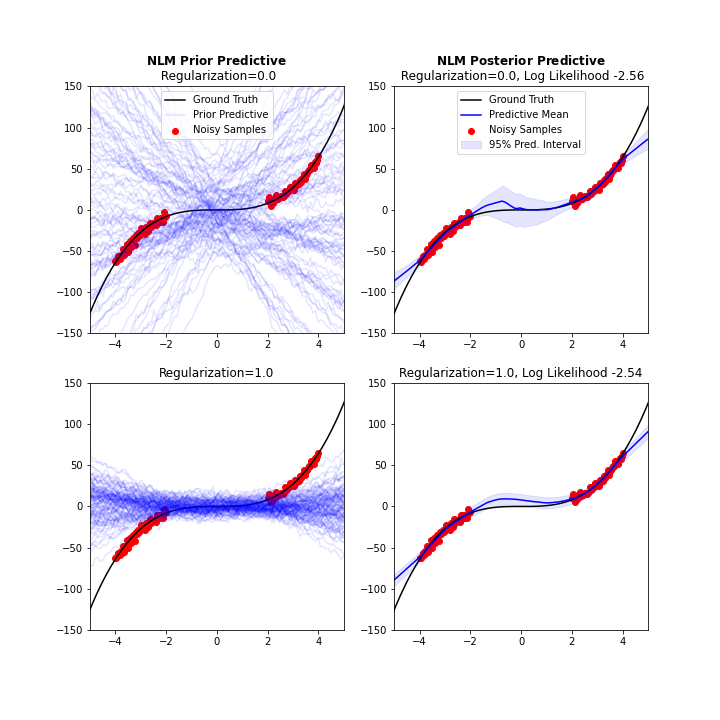

In [2]:
Image(filename='fig_final/NLM_Predictives.png')

## Technical Content (High Level)
_What are the high level ideas behind their technical contribution?_

The LUNA model contains two key modifications to the neural network of an NLM. First, the network is trained to produce $M$ auxiliary outputs that collectively contribute to the loss function. For a given observation, each of the $M$ auxiliary outputs predicts the output $Y$ while using different final layer parameters. Second, the objective function is augmented with a term explicitly encouraging diversity amongst the $M$ functions that map input to each auxiliary output. The additional loss term uses cosine-similarity to measure differences between pairwise combinations of outputs and penalizes the loss function if two outputs are similar. The total loss function maintains a maximum likelihood and $\ell_2$ regularization component, thus ensuring the overall fit of the model to the training data. 

By balancing model fit with diversity in the training phase, the resulting weights of the network necessarily take on diverse values that fit the data and form an expressive basis for regression. In the Bayesian linear regression step, the auxiliary outputs are discarded, but the expressiveness of the weights trained for diversity remains.

The figure below demostrates LUNA's ability to model reasonable out of sample uncertainty, relative to NLM, while maintaining
reasonable test log likelihood. See `LunaBaseDemo.ipynb` for details on figure creation.


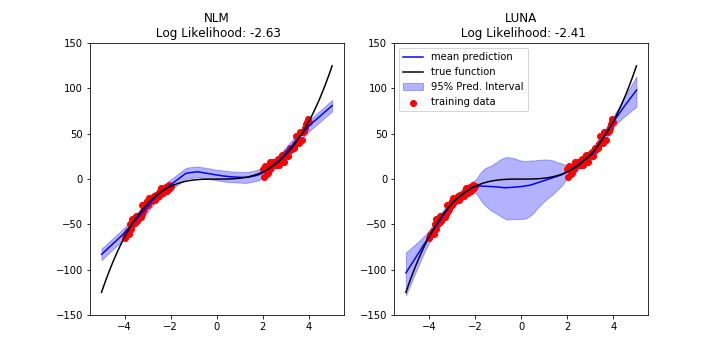

In [3]:
Image(filename='fig_final/LUNA_NLM_Base.png')

## Technical Content (Details)
_Highlight (not copy and paste entire sections) the relevant details that are important to focus on (e.g. if there's a model, define it; if there is a theorem, state it and explain why it's important, etc)._

In more technical terms, suppose we have training data that consist of features $X \in \mathbb{R}^{N \times D}$ and target $Y \in R^N$, where $N$ is the number of observations, and $D$ is the number of features. In the first stage of LUNA training, we train a neural network with $K$ hidden layers, each with width $L_k$ using our training data. To train, we use the following objective function ($\mathcal{L}_{LUNA}$), which contains terms for both the fit ($\mathcal{L}_{fit}$) and the diversity ($\mathcal{L}_{diverse}$) of the auxiliary functions:
$$
\mathcal{L}_{LUNA}(\Psi) = \mathcal{L}_{fit}(\Psi) - \lambda \cdot \mathcal{L}_{diverse}(\Psi)
$$

where $\Psi$ consists of all weights used in training the neural network (including the final layer of weights that are retrained in the Bayesian regression phase); and where $\lambda$ controls how much weight is given to the diversity metric. Notice that we seek to maximize this objective function over $\Psi$.

$\mathcal{L}_{fit}$ evaluates the model's fit to the training data using the average log likelihood across all of the auxiliary outputs with $\ell_2$ regularization:
$$
\mathcal{L}_{fit}(\Psi) = \frac{1}{M}\sum_{m=1}^M log N(y;f_m(X),\sigma^2 I) - \gamma\lVert\Psi\rVert_2^2 
$$

Lastly, we define $\mathcal{L}_{diverse}$, which measures diversity in the auxiliary functions outputs. It sums the squared cosine similarity between the gradient of every pairwise combination of auxiliary functions, thus rewarding the model when auxiliary functions extrapolate away from the training data in different directions. In practice, the gradients in the diversity score are approximated with finite differences:
$$
\mathcal{L}_{diverse}(\Psi) = \sum_{i=1}^M \sum_{j=i+1}^M \text{CosSim}^2\left(\nabla_xf_i(x_{train}), \nabla_xf_j(x_{train})\right)
$$

Once trained, the $f$ maps from: $\mathbb{R}^D \to \mathbb{R}^M$. 

Next we chop off the final set of weights, producing a feature map that now predicts the final hidden layer: $\phi_{\theta}: \mathbb{R}^{D} \to \mathbb{R}^{L_K}$, where $\theta \subset \Psi$ contains the network weights from the $K-1$ layers. As a last step, we apply a prior to the last layer of weights, and run a Bayesian linear regression to predict our target data $Y$. In other words, the Bayesian linear regression takes the form of:
$$
y \sim \mathcal{N}(\mathbf{\Phi}_{\theta}\mathbf{w},\sigma^2\mathbf{I}), \hspace{0.5cm} w \sim \mathcal{N}(\mathbf{0}, \alpha\mathbf{I})
$$
where $\mathbf{\Phi}_{\theta}$ is a $N \times (L_K+1)$ matrix that applies the feature map to $X$ and augments the resulting $N \times L_K$ matrix with a row of ones for the bias; $\mathbf{w}$ represents the final layer of weights; and the covariance of $y$ and the prior over $w$ are identity matrices multiplied by a constant ($\sigma^2$ or $\alpha$, respectively). This last formula illustrates how the fitted weights of the neural network serve as the basis for the Bayesian linear regression. 


### Snapshots of the posterior predictive and auxilliary functions while training

The left column in the figure below demonstrates how the cosine similarity score function incentivizes auxillary 
functions to diversify in the data gap as the optimization progresses. Consequently, the posterior predictives in the right column 
 reflect increased uncertainty in out-of-sample regions. See `LUNABaseDemo.ipynb` for code to recreate this figure.

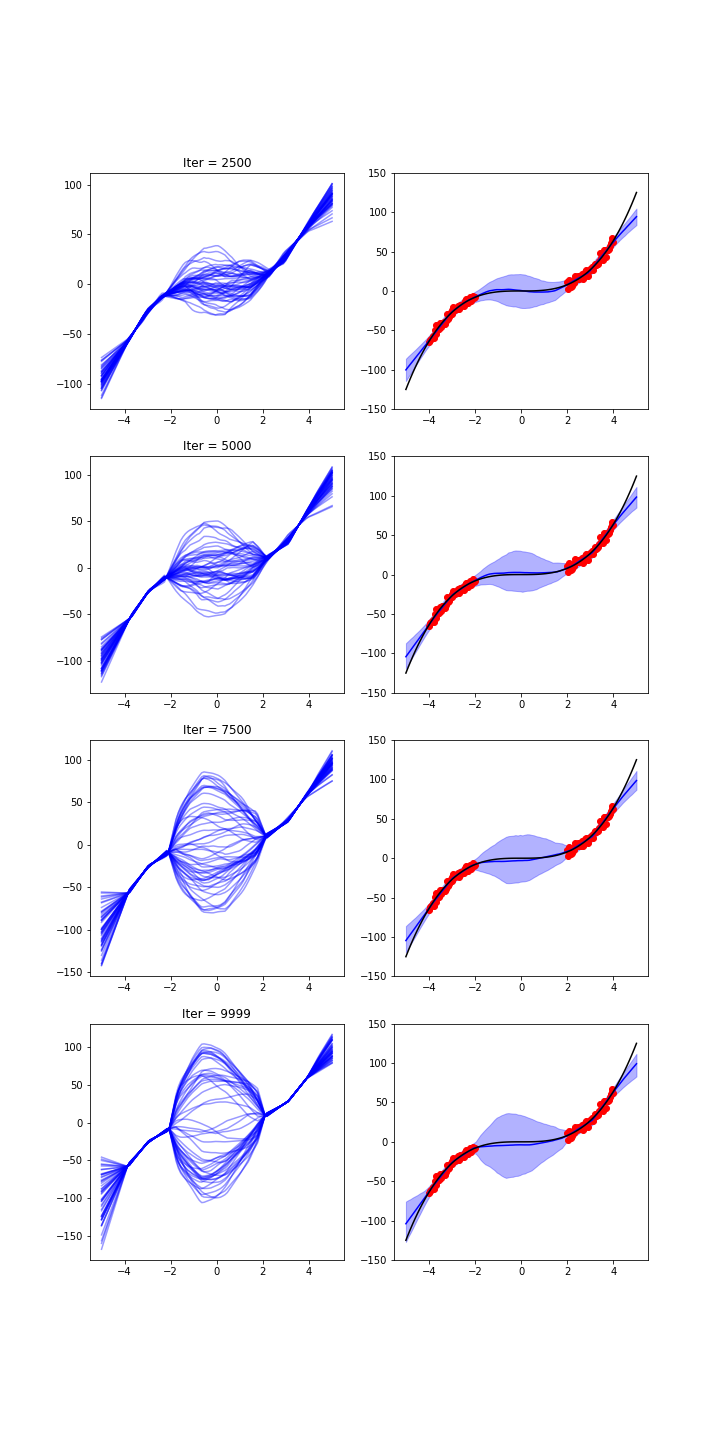

In [ ]:
Image(filename='fig_final/luna_training.png')

## Experiments
_Which types of experiments were performed? What claims were these experiments trying to prove? Did the results prove the claims?_

### Datasets:
The authors experimented on 3 internally-designed simple toy datasets with gaps that, though simple in appearance, demonstrate a major failure mode for many neural network designs.

In addition, 5 externally-sourced datasets (from the Machine Learning Repository at UC Irvine) were given artificially-created gaps to test model robustness to data limitations.

### Finding 'Gold Standard' Hyperparameters with the Cubic Gap Dataset
Below, we detail how the authors trained an NLM and LUNA models on their cubic gap dataset, as we relied on this dataset to validate certain experiments from the paper. Note that these details are reflected in `config.py`.

First, they generate 100 training points from the following function:

$$
y = x^3 + \epsilon, \epsilon \sim N(0,3^2)
$$
and only sample points in $x\in [-4,-2] \bigcup  [2,4]$, creating a missing data region. 

In the first stage of NLM and LUNA training, they fit a neural network with 2 hidden layers, a 
width of 50 for each layer, and with ReLu activation functions. Note that the neural network used in NLM has 1 output node while the one used in LUNA has 50 output nodes for the auxiliary functions. 

To maximize the objective function defined above, the authors use the Adam Optimizer and run 
for a maximum of 10,000 iterations, with a step size of 0.01.

For the Bayesian linear regression component of the NLM, they assumed the prior variance 
$\alpha$ of the weights $w$ is 1 and the variance $\sigma^2$ of $y$ is 9.  

To find a "gold standard" implementation of regular NLM, they train several 
NLMs over a variety of regularization values, $\gamma$, and conclude that 
$\gamma$ = 8.37 maximizes test log likelihood.

To find a 'gold standard' implementation of LUNA, they train several LUNA models
 over a grid of regularization values $\gamma$ and diversity score weights $\lambda$. They
  conclude that $\gamma$ = 0.1 and $\lambda$ = 1 maximize test log likelihood.


### Experiment Goals:
The primary goal of the experiments is to show that LUNA holds up against other models that attempt to
model out-of-sample uncertainty, in particular:

- NLM
- Monte Carlo with dropout model
- MAP estimation from a nueral network
- Bootstrapped ensemble model
- Bayesian neural network with HMC sampling (gold standard, provides useful uncertainties exploring the posterior)
- Gaussian process (gold standard, the improv jazz of modeling, and equivalent to a NLM with $\infty$ nodes in its feature basis).

They compared model performance across a variety of tasks:

1. **Visualization:** plot the uncertainty in the posterior predictive. Does the model have higher uncertainty in the gap than in the data-rich region?
2. **Generalization:** measure model performance using test data drawn from the same data generating process as the training data
3. **Transfer learning:** measure model performance after re-training the Bayesian layer on data within the gap
4. **Bayesian optimization:** measuring how quickly a model locates a global maximum
5. **Comparison:** evaluate the fit and epistemic uncertainty between the Gap and Not Gap versions of the 5 UCI datasets.


Model fit is measured by both low MSE and high log-likelihood, and epistemic uncertainty is measured by the standard deviation of the posterior predictive. The authors use epistemic uncertainty to "identify" gaps in the data by building models with lots of agreeing predictions in the data-rich regions and disagreeing predictions in the gaps. Epistemic uncertainty should therefore, for a robust model, be higher on the gap dataset than on the non-gap dataset.

Each model is initialized with the same architecture: a ReLU-activation neural network with 2 layers and a width of 50 nodes per layer.


### Results


#### Visualizing Uncertainty Spread
The LUNA model found a better uncertainty spread in the gap than the NLM et al. did. Notably, it achieved comparable uncertainty spread to the gold standards.

#### Generalization and Transfer Learning
All of the methods worked well when the dimension of their basis expansion $\rightarrow \infty$ (aka 500), but LUNA achieves notably better performance for low-dimension basis expansions in the generalization and transfer-learning tasks.

#### Bayesian Optimization
LUNA typically took a comparably small, or smaller, number of iterations to converge than the other methods (including the gold standards).

#### Comparing MSE, Log-Likelihood, and Epistemic Uncertainty on the UCI Datasets
LUNA performed better than the NLM and MCD methods at achieving a higher epistemic uncertainty on the Gap vs. Non-Gap datasets while still finding a strong fit for both datasets. 



## Evaluation
_(your opinion) - do you think the work is technically sound? Do you think the proposed model/inference method is practical to use on real data and tasks? Do you think the experimental section was strong (there are sufficient evidence to support the claims and eliminate confounding factors)?_

The work is sound, though we wish we were good enough at this to find flaws in our professor's work.

The paper effectively communicates LUNA's key innovation in the objective function. 
The experiments thoroughly demonstrate the effectiveness of LUNA on the toy datasets.
 The experimentation design is useful because, in many downstream tasks, an algorithm should properly identify gaps in its training data and 
 exercise hesitance in human contexts. This principle seems to embody sensible wisdom, that 
 one should be confident when equipped with sufficient data while uncertain/hesitant where appropriate. 

 While the paper effectively demonstrated an NLM's inability to produce reasonable uncertainty estimates across a variety of hyperparameters
 (i.e. Figures 6 -10), we would have liked to see similar figures for a LUNA model, to show that LUNA's uncertainty can be 
 robust to various hyperparameter values.

The experiments with the UCI datasets are less interpretable because the data is high dimensional,
 making it impossible to visualize simple "uncertaity bumps" (like the toy dataset). 
 But the change in epistemic uncertainty (posterior predictive standard deviation) 
 between the Gap and Non-Gap datasets is a useful numerical proxy of how much more 
 hesitant LUNA can be in the presence of gaps in the data. 
 Lastly, the authors chose data from a variety of human contexts, demonstrating LUNA's flexibility.
 



#### Failure Mode: Categorical Data Uncertainty

Though LUNA performed well on the toy and UCI datasets, it failed to provide desirable uncertainty estimation on a 2-D dataset with binary outcome data.
 Professor Pan's IACS talk in September inspired this failure mode.

The figure below, created in `LUNA_2D_Demo.ipynb`, shows the epistemic uncertainty of LUNA performing binary classification on a 2-D dataset.

LUNA is able to create decision boundaries that separate the data but underestimate uncertainty (posterior predictive standard deviation) in the bottom-left and upper-right corners of the plot. A classifier better equipped to handle uncertainty in this context would have epistemic uncertainty correlate consistently with distance from the training data, thereby encircling a region close to each clump of training data.

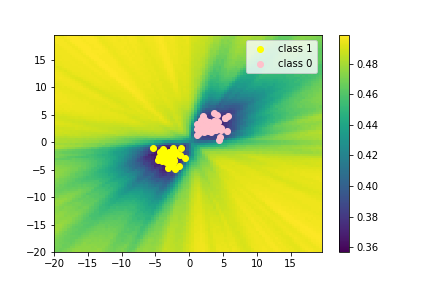

In [4]:
Image(filename='fig_final/luna2dscratch_standard deviation.png')

## Future Work 
_(for those interested in continuing research in a related field) - do you think you can suggest a concrete change or modification that would improve the existing solution(s) to the problem of interest? Try to implement some of these changes/modifications._

We made no substantial changes to the LUNA algorithm and replicated experiments using the same hyperparameters used by the authors. We performed hyperparameter searches for various regularization strengths for NLM and LUNA and found similar results.

In addition to these replications, we implemented an additional method of model evaluation, a "trace plot" of the posterior predictive interval displayed after 2500, 5000, 7500, and 10,000 iterations. This exercise helped us assess the model behavior more clearly.

One further avenue of model evaluation we believe is worthwhile is to test LUNA on noisy data without artificially-created gaps. In deployment in real-life, the missingness of data is typically unanticipated. However, the authors evaluated the quality of LUNA's posterior predictive on toy datasets and real datasets with artificially created gaps. Testing LUNA, without knowing in advance what the gaps in the data are, would provide a more comprehensive understanding of LUNA's strengths and weaknesses.

It's also too bad that LUNA takes longer to train compared to a vanilla NLM. For us, LUNA training was about 100x slower. This means tuning over various
hyperparameters could take even more time. We wonder if LUNA can be sped up by sampling the observations used to calculate the cosine similary score, 
instead of using the whole training set. Further, perhaps the cosine similarity score only needs to be evaluated every $n$th iteration, while maintaining good uncertainty. 


Additionally, we believe this work highlights the need for new methods in evaluating machine learning models that incorporate 
metrics for uncertainty quality. Relying on log likelihood alone lacks any measurement of predictive uncertainty in data-scarce
regions, which is crucial for uncertainty detection in high-risk use cases. And while it's easy for the practioner to vizually evaluate LUNA's ability to model uncertainty on 1- and 2-D dimensional input data,
without a more universal metric for uncertainty quality, the practitioner can only rely Luna's theoretical backbone (i.e., an objective function that incentivizes functional diversity) to produce high dimensional uncertainty estimates. 

Given the lack of a universal uncertainty metric, we wonder if the practitioner can visually assess model uncertainty from high dimensional data by using
a dimension reduction pre-processing step. In other words, first reduce the dimensionality of the data, then train LUNA on the low dimensional embedding.
 If the dimension reduction algorithm could faithfully model distances between points and 
across training data clusters, the practioner could accurately predict outcomes and model uncertainty. Given that the low dimensional embedding must highlight distances
 between clusters of high dimensional training data, we believe the t-SNE dimension reduction algorithm would be a
  promising choice.


## Broader Impact 
_How does this work potentially impact (both positively and negatively) the broader machine learning community and society at large when this technology is deployed? In the applications of this technology, who are the potentially human stakeholders? What are the potential risks to the interest of these stakeholders in the failure modes of this technology? Is there potential to exploit this technology for malicious purposes?_

Uncertainty estimation has long been an underdeveloped aspect of machine learning, since practitioners often evaluate models only with MSE or log-likelihood (their ability to fit the train/test data) without worrying about mistakes on other types of data. In human contexts, such as facial recognition and automated medical diagnoses, model mistakes (caused by under-training on data from certain categories of individuals) can have disastrous consequences. These model mistakes are often skewed in frequency and severity by protected categories of individuals such as race and gender, so it is imperative that practitioners address these issues during model development before deployment, as well as including a mechanism for models themselves to avoid these issues as much as possible during deployment itself. Uncertainty estimation therefore acts as a mediating factor against harmful mis-predictions, by equipping models with the ability to *avoid* making predictions when detecting higher uncertainty (i.e. a higher likelihood of making a mistake). Several existing methods already allow for uncertainty estimation in neural networks, and LUNA is a contribution to that body of work as a comparable alternative in speed and scalability.

The LUNA paper does not introduce further risks to machine learning. The authors' work helps establish a baseline norm of responsibility and accountability by formally evaluating the failure modes of a popular and under-explored new ML design in the NLM. If machine learning as a practice is moving in the direction of standardized quality assurance benchmarks, one such benchmark should be replicating the authors' gap vs. non-gap comparison of epistemic uncertainty, showing that LUNA was better prepared than the NLM at reporting higher uncertainty on the gap dataset.

One potential risk of the use of many deep learning methods generally: it is easy to think the model is working fine during development, when in reality it is deeply flawed. Initially, our team mis-calculated the objective function in a way that did not produce bad results for $n < 6,000$ish iterations - in fact, the preliminary results were consistent with our expectations of a fully functioning LUNA model. We recognized the flaw late in development once we finally began testing with 10,000 iterations. 

Deep learning with uncertainty estimation is extremely useful in prediction and inference; yet, the industry as a whole has allowed for years of flaws to go unaddressed. Therefore practitioners need to be held to the highest standards in quality assurance processes to prevent the deployment of harmfully deficient models.



## References

\[1] Kashmir Hill. “Wrongfully Accused by an Algorithm”. In _The New York Times_ (June 2020). URL: [https://www.nytimes.com/2020/06/24/technology/facial-recognition-arrest.html](https://www.nytimes.com/2020/06/24/technology/facial-recognition-arrest.html) (visited on 12/14/2020).

\[2] Larrazabal, A., Nieto, N., Peterson, V., Milone, D. and Ferrante, E., 2020. Gender imbalance in medical imaging datasets produces biased classifiers for computer-aided diagnosis. In _Proceedings of the National Academy of Sciences_, 117(23), pp.12592-12594, 2020.

\[3] Lohr, Steve. "Facial Recognition Is Accurate, if You're a White Guy." In _The New York Times_ (February 2020). URL: [https://www.nytimes.com/2018/02/09/technology/facial-recognition-race-artificial-intelligence.html](https://www.nytimes.com/2018/02/09/technology/facial-recognition-race-artificial-intelligence.html) (visited on 12/14/2020).

\[4] Yao, J., Pan, W., Ghosh, S., and Doshi-Velez, F. Quality of uncertainty quantification for bayesian neural network inference. In _International Conference on Machine Learning (ICML): Workshop on Uncertainty & Robustness in Deep Learning_, 2019.

\[5] Rasmussen, C. and Williams, C. _Gaussian Processes for Machine Learning_. Adaptive Computation and Machine Learning. MIT Press, Cambridge, MA, USA, January 2006.

\[6] Radford M. Neal. _Bayesian Learning for Neural Networks_. Ed. by P. Bickel et al. Vol. 118. Lecture Notes in Statistics. New York, NY: Springer New York, 1996. DOI: 10.1007/978-1-4612-0745-0. URL: [http://link.springer.com/10.1007/978-1-4612-0745-0](http://link.springer.com/10.1007/978-1-4612-0745-0) (visited on 12/13/2020).

\[7] Jasper Snoek et al. “Scalable Bayesian Optimization Using Deep Neural Networks”. In _arXiv:1502.05700 \[stat]_ (July 2015). arXiv: 1502.05700. URL: [http://arxiv.org/abs/1502.05700](http://arxiv.org/abs/1502.05700) (visited on 12/13/2020).

\[8] Weilin Zhou and Frederic Precioso. “Adaptive Bayesian Linear Regression for Automated Machine Learning”. In _arXiv:1904.00577 \[cs, stat]_ (Apr. 2019). arXiv: 1904.00577. URL: [http://arxiv.org/abs/1904.00577](http://arxiv.org/abs/1904.00577)  (visited on 12/13/2020).

\[9] Ober, S. W. and Rasmussen, C. E. Benchmarking the neural linear model for regression. In _Advances in Approximate Bayesian Inference (AABI)_, 2019.

\[10] Pinsler, R., Gordon, J., Nalisnick, E., and Hernández- Lobato, J. M. Bayesian batch active learning as sparse subset approximation. In _Advances in Neural Information Processing Systems 32_, pp. 6359–6370, 2019.